# Análisis exploratorio de datos

El conjunto de datos con el que trabajaremos es una recopilación de situaciones de ajedrez en las cuales el rey y la torre blanca intentan dar mate al rey negro en un determinado número de jugadas. METER LINK

El objetivo es determinar, a partir de las posiciones del rey y la torre negra, el número de movimientos necesario para dar mate al rey negro. Es posible que la configuración de piezas no dé lugar a un mate y acabe en tablas. Además, todos los datos están generados asumiendo un estilo de juego óptimo usando el estimador de teoría de juegos _Minimax_

Nuestro conjunto de datos está formado por 7 columnas, de las cuales las 6 primeras serán las variables predictoras y la última la variable a predecir:

1. Columna del rey blanco (wkc)
2. Fila del rey blanco (wkr)
3. Columna de la torre blanca (wrc)
4. Fila de la torre blanca (wrr)
5. Columna del rey negro (bkc)
6. Fila del rey negor (bkr)
7. Número de movimientos óptimos para que ganen las blancas. Varían del 0 al 16 más la posibilidad de empate.

Nuestro trabajo será construir modelos que sean capaces de predecir el número de movimientos óptimos para ganar a partir de las posiciones de las tres piezas.



In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

Importamos los datos usando pandas:

In [12]:
data = pd.read_csv("krkopt.data", header=None)
data.columns = ["wkc", "wkr", "wrc", "wrr", "bkc", "bkr", "opt rank" ]

Veamos la estructura del conjunto:

In [13]:
data

,wkc,wkr,wrc,wrr,bkc,bkr,opt rank
0,a,1,b,3,c,2,draw
1,a,1,c,1,c,2,draw
2,a,1,c,1,d,1,draw
3,a,1,c,1,d,2,draw
4,a,1,c,2,c,1,draw
...,...,...,...,...,...,...,...
28051,b,1,g,7,e,5,sixteen
28052,b,1,g,7,e,6,sixteen
28053,b,1,g,7,e,7,sixteen
28054,b,1,g,7,f,5,sixteen


Existe un total de 28056 casos para 7 columnas. 

Comprobamos si existen valores perdidos:

In [14]:
np.sum(data.isnull())

wkc         0
wkr         0
wrc         0
wrr         0
bkc         0
bkr         0
opt rank    0
dtype: int64

No existen valores omitidos, por lo que podemos usar todos los casos sin ningún problema.

Estamos interesados en predecir los valores de _otp rank_, nos preguntamos cuál es la distribución de los casos para esta columna:

<AxesSubplot:xlabel='opt rank', ylabel='count'>

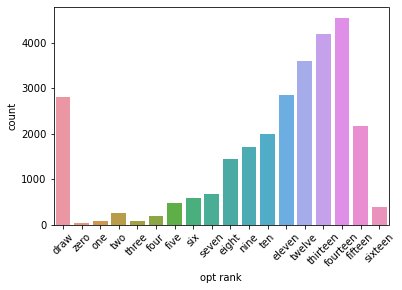

In [15]:
plt.xticks(rotation=45)
sns.countplot(x='opt rank',
             data=data)

In [16]:
from collections import Counter
counter = Counter(data['opt rank'])
for k,v in counter.items():
	per = v / len(data['opt rank']) * 100
	print('Class=%s, n=%d (%.3f%%)' % (k, v, per))

Class=draw, n=2796 (9.966%)
Class=zero, n=27 (0.096%)
Class=one, n=78 (0.278%)
Class=two, n=246 (0.877%)
Class=three, n=81 (0.289%)
Class=four, n=198 (0.706%)
Class=five, n=471 (1.679%)
Class=six, n=592 (2.110%)
Class=seven, n=683 (2.434%)
Class=eight, n=1433 (5.108%)
Class=nine, n=1712 (6.102%)
Class=ten, n=1985 (7.075%)
Class=eleven, n=2854 (10.173%)
Class=twelve, n=3597 (12.821%)
Class=thirteen, n=4194 (14.949%)
Class=fourteen, n=4553 (16.228%)
Class=fifteen, n=2166 (7.720%)
Class=sixteen, n=390 (1.390%)


Tal y como vemos, se trata de un problema de clasificación desbalanceada. Existe una gran tendencia en la distribución a necesitar un número de entre diez y catorce pasos para acabar la partida. Destacamos, de igual manera, la importante cantidad de veces que acaba en tablas. Hay muy poca representanción de partidas que puedan acabar en el rango de uno a siete movimientos.

Este tipo de conjuntos de datos son problemáticos ya que el gran desbalanceo existente entre las clases impide que los modelos construidos consigan buenas métricas en la clasificación. Por ello, usaremo, además de los datos _raw_, la herramiento SMOTE, que realiza un sobremuestreo de los datos. Su funcionamiento es parecido a la interpolación, pero mucho más complejo.

Continuamos con la distribución de las demás clases en cada variable predictora:

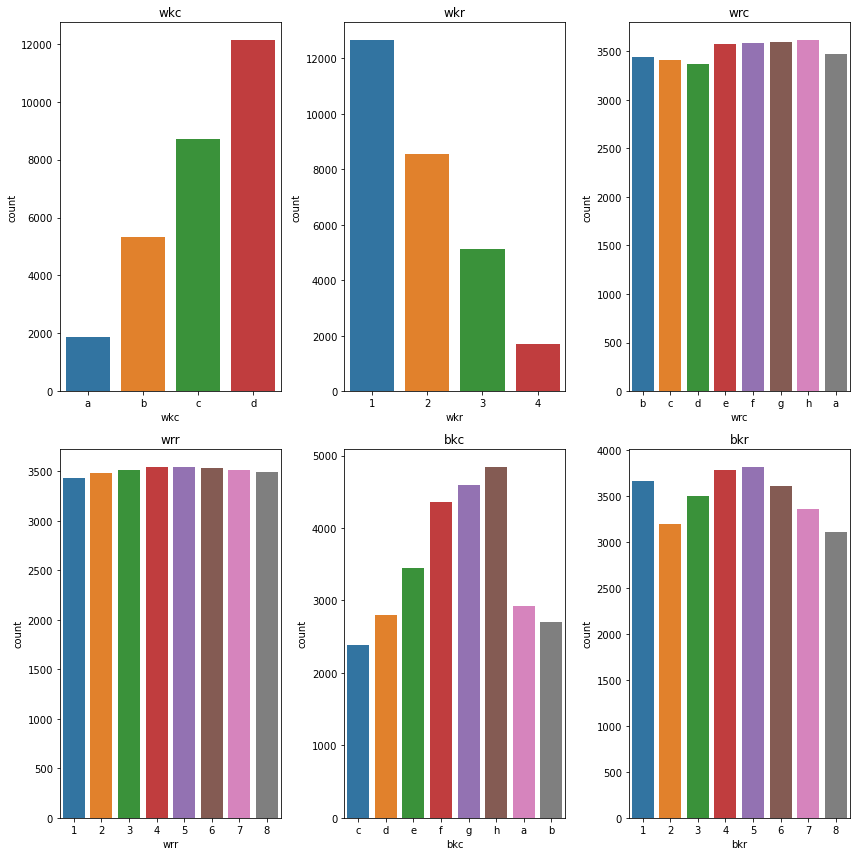

In [18]:
f, ax = plt.subplots(2,3, figsize=(12,12) )
sns.countplot(ax= ax[0,0], x='wkc',
             data=data)
sns.countplot(ax= ax[0,1], x='wkr',
             data=data)
sns.countplot(ax= ax[0,2], x='wrc',
             data=data)
sns.countplot(ax= ax[1,0], x='wrr',
             data=data)
sns.countplot(ax= ax[1,1], x='bkc',
             data=data)
sns.countplot(ax= ax[1,2], x='bkr',
             data=data)


ax[0,0].set_title("wkc")
ax[0,1].set_title("wkr")
ax[0,2].set_title("wrc")
ax[1,0].set_title("wrr")
ax[1,1].set_title("bkc")
ax[1,2].set_title("bkr")

plt.tight_layout()
plt.savefig('foo.pdf', transparent=True)

Existe una mayor homogeneidad en las variables predictoras correspondientes a la posición de las torres. 

Es curioso que el rey blanco suele estar en la columna d en la primera fila, mientras que el rey negro presenta una distribución mucho más variada.

Todavía no hemos realizado ningúna conversión de los tipos ya que preferimos aplazarlo hasta la aplicación de determinados algoritmos, que nos exijan la codificación de las columnas en un deterimnado tipo.

## Importancia de variables

Podemos utilizar algoritmos basados en árboles de decisión como RandomForest para estimar qué variables predictoras importan más a la hora de determinar la variable a predecir.

Para ello utilizaremos el paquete Scikit-learn. En primer lugar codificaremos numéricamente las variables categóricas.

In [19]:
data_aux = data.copy()
data_aux[['wkc', 'wrc', 'bkc']] = data_aux[['wkc', 'wrc', 'bkc']].astype('category')

data_aux['wkc'] = data_aux['wkc'].cat.codes
data_aux['wrc'] = data_aux['wrc'].cat.codes
data_aux['bkc'] = data_aux['bkc'].cat.codes

Entrenamos un modelo de RandomForest

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data_aux.drop("opt rank", axis=1), data_aux['opt rank']
                                                    ,test_size=0.2)
feature_names = [f'feature {i}' for i in range(data_aux.drop('opt rank', axis=1).shape[1])]

forest = RandomForestClassifier(random_state=0)
forest.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

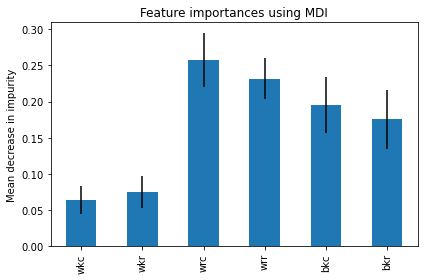

In [22]:
importances = forest.feature_importances_
std = np.std([
    tree.feature_importances_ for tree in forest.estimators_], axis=0)

forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
ax.set_xticks([0,1,2,3,4,5]) # values
labels = list(data_aux.columns[:-1])
ax.set_xticklabels(labels) # labels
positions = (1, 2, 3,4, 5)


fig.tight_layout()

Las variables más importantes a la hora de determinar el número de pasos son las coordenadas de la torre junto a las coordenadas del rey negro. Parece que la posición del rey blanco no es tan importante como el papel de la torre a la hora de ir _acorralando_ al rey negro.

Podemos dar por finalizado el análisis exploratorio de datos, ya que no necesitamos hacer ningún test estadístico o análisis continuo de los datos debido a la naturaleza categórica de los mismos. Además, la distribución de clases por columna no sigue ninguna distribución normal, atendiendo a las figuras obtenidas.

# Creación de modelos con redes neuronales con TensorFlow

De acuerdo a lo aprendido en la asignatura, utilizaremos TensorFlow en su versión 2.5 para crear distintos modelos de redes neuronales para abordar este problema de clasificación. Los datos que usaremos son los originales y los balanceados usando SMOTE. 

Para cada conjunto crearemos distintos modelos de perceptrón multicapa en los cuales variaremos la profundidad del mismo (número de capas) así como la cantidad de neuronas por capa. 

Haremos uso de técnicas como dropout y callbacks. La técnica del dropout consiste en desactivar ciertas neuronas por capa de forma aleatoria en cada época con el fin de evitar que la red neuronal sobreaprenda. Con esta idea, se debe poder conseguir redes neuronales de mayor tamaño que permitan aprender más características del conjunto de datos aún sin sobreaprender. 

Los callbacks son utilidades que incluye Tensorflow que facilitan el entrenamiento de los modelos. Podemos guardar en disco el modelo que mejor resultado da en función de una métrica de control. En nuestro caso, estamos interesados en la función _EarlyStopping_ que permite acabar el entrenamiento de forma automática si, tras un número determinado a elegir de épocas, la métrica que elijamos no ha mejorado. Esta ventaja es fundamental ya que nos ahorra tener que incluir el número de épocas dentro de los parámetros tuneables durante el entrenamiento.

Para realizar el entrenamiento, estamos usando Linux junto a una tarjeta gráfica Nvidia 1070 max-q que nos ayuda a acelerar el trabajo de forma drástica. El entorno de Linux permite la configuración de las librerías CUDA de forma sencilla.

De entre los modelos vistos en clase, nos hemos decantado por el perceptrón multicapa ya que es el que más fácilmente se adapta a este problema. Por un lado, no podemos usar las redes convolucionales, joya de la corona del deep learning actualmente, ya que se usan en reconomiento de imágenes. No sabemos cómo utilizar las capas convolucionales en este tipo de datos. Muchas funcionalidades de TensorFlow no son usadas, como _DataAugmentation_, que permite variar el conjunto de entrenamiento para que la red neuronal tenga más variedad durante el mismo. Por otro lado, los mapas autogenerativos así como las redes neuronales con funciones de base radial no tienen suficiente documentación en internet para este tipo de problemas. Las redes neuronales recurrentes no se suelen usar en estas situaciones.

## Datos _raw_ con _smote_ y _dropout_

Importamos los datos y separamos en variables predictoras: X y variable a predecir: y.

In [4]:
import pandas as pd
import numpy as np
data = pd.read_csv("krkopt.data", header=None)
data.columns = ["wkc", "wkr", "wrc", "wrr", "bkc", "bkr", "opt rank" ]
X = data.iloc[:, 0:6]
y = data['opt rank']
X

,wkc,wkr,wrc,wrr,bkc,bkr
0,a,1,b,3,c,2
1,a,1,c,1,c,2
2,a,1,c,1,d,1
3,a,1,c,1,d,2
4,a,1,c,2,c,1
...,...,...,...,...,...,...
28051,b,1,g,7,e,5
28052,b,1,g,7,e,6
28053,b,1,g,7,e,7
28054,b,1,g,7,f,5


Codificamos los valores "a", "b", "c" de las variables categóricas a enteros para que puedan ser utilizadas por las redes neuronales

In [5]:
X["wkc"]=X["wkc"].astype('category')
X["wrc"]=X["wrc"].astype('category')
X["bkc"]=X["bkc"].astype('category')
X["wkc"]=X["wkc"].cat.codes
X["wrc"]=X["wrc"].cat.codes
X["bkc"]=X["bkc"].cat.codes
y = y.astype('category')
y = y.cat.codes
X

,wkc,wkr,wrc,wrr,bkc,bkr
0,0,1,1,3,2,2
1,0,1,2,1,2,2
2,0,1,2,1,3,1
3,0,1,2,1,3,2
4,0,1,2,2,2,1
...,...,...,...,...,...,...
28051,1,1,6,7,4,5
28052,1,1,6,7,4,6
28053,1,1,6,7,4,7
28054,1,1,6,7,5,5


In [6]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

Creamos los conjuntos de entrenamiento y test con una proporción 80-20 usando herramientas de _sklearn_ y utilizamos oversampling con _smote_

In [7]:

X_train, X_test, y_train, y_test = train_test_split(X,
                                                   y, test_size=0.2,
                                                   random_state = 1)

from imblearn.over_sampling import SMOTE
oversample = SMOTE()


X_smote, y_smote = oversample.fit_resample(X, y)

X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(X_smote,
                                                   y_smote, test_size=0.2,
                                                   random_state = 1)



y_train = to_categorical(y_train)
y_test  = to_categorical(y_test)
y_train_smote = to_categorical(y_train_smote)
y_test_smote = to_categorical(y_test_smote)

Como vemos, _Smote_ permite utilizar datos categóricos aunque no sea lo más recomendable

In [9]:
X_smote

,wkc,wkr,wrc,wrr,bkc,bkr
0,0,1,1,3,2,2
1,0,1,2,1,2,2
2,0,1,2,1,3,1
3,0,1,2,1,3,2
4,0,1,2,2,2,1
...,...,...,...,...,...,...
81949,2,3,0,1,2,1
81950,2,2,0,7,0,2
81951,2,1,0,8,0,1
81952,2,1,0,8,0,1


Estandarizamos los datos de entrada usando _zscore_.

In [10]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

scaler = StandardScaler().fit(X_train_smote)
X_train_smote = scaler.transform(X_train_smote)
X_test_smote = scaler.transform(X_test_smote)

### Definición de funciones

Definimos tres funciones que nos serán útiles para automatizar el proceso:
- _make_my_model_multi_ permite crear un perceptrón multicapa proporcionándole la estructura de la forma $[n_1, n_2, ..., n_i,..., n_N]$ donde $n_i$ es el número de neuronas de la capa oculta $i$. Además de otros parámetros como la forma de entrada, salida y la función de activación que queramos usar.
- _compile_fit_multiclass_ entrena un modelo de entrada con el conjunto de entrenamiento usando un conjunto de validación 80-20 y produce predicciones con un conjunto test. Utilizamos la herramienta _ModelCheckpoint_ para guardar el mejor modelo durante el entrenamiento y _EarlyStopping_ para parar el entrenamiento si el valor de _loss_ en el conjunto de validación no mejora en 10 épocas. Así evitamos el sobreaprendizaje.

- _compute_metrics_multiclass_ calcula las métricas precision, recall, F1 y Kappa a partir de las predicciones y los valores exactos de test.

- _make_my_model_multi_dropout_ es una modificación que permite crear un modelo introduciendo capas internas de dropout. La estructura de la red se introduce de la forma $[n_1, n_2, ..., n_i,..., n_N]$ donde $n_i$ es el número de neuronas de la capa $i$ si escribimos un número entero o una capa dropout con un valor  de desactivación $n_i$ si introducimos un elemento de tipo carácter. Por ejemplo, [50, "0.2", 50, "0.2"] creará unas capas ocultas de la forma: capa con 50 neuronas, dropout 0.2, capa con 50 neuronas y dropout de 0.2.

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


checkpoint_filepath = '/tmp/checkpoint'
from sklearn.metrics import confusion_matrix, precision_score, \
f1_score, cohen_kappa_score, recall_score

def make_my_model_multi( units_per_layer, input_s, output_s, activation_='relu'):
    model = Sequential()
    depth = len(units_per_layer)
    model.add(Dense(units_per_layer[0], activation=activation_, input_shape=(input_s,)))
    for i in range(1, depth):
        model.add(Dense(units_per_layer[i], activation=activation_))
    model.add(Dense(output_s, activation = 'softmax'))   
    
    return model




def compile_fit_multiclass(modelo, X_train, X_test, y_train, batch, epochs, verbose=0):
    modelo.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])
    
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=True)

    model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                        save_weights_only=True,
                                                        monitor='val_loss',
                                                        mode='min',
                                                        save_best_only=True,
                                                        verbose=False)

    modelo.fit(X_train, y_train, epochs=epochs, batch_size=batch, verbose=verbose, validation_split=0.2, callbacks = [early_stopping, model_checkpoint])
    model.load_weights(checkpoint_filepath)
    predictions = modelo.predict(X_test)
    return predictions

def compute_metrics_multiclass(y_test, y_pred):
    results=[]
    results.append(precision_score(y_test, np.round(y_pred), average="micro"))
    results.append(recall_score(y_test, np.round(y_pred), average="micro"))
    results.append(f1_score(y_test, np.round(y_pred), average="micro"))
    results.append(cohen_kappa_score(y_test, np.round(y_pred)))
    return results


from tensorflow.keras.layers import Dropout

def make_my_model_multi_dropout( units_per_layer, input_s, output_s, activation_='relu'):
    model = Sequential()
    depth = len(units_per_layer)
    model.add(Dense(units_per_layer[0], activation=activation_, input_shape=(input_s,)))
    for i in range(1, depth):
        if isinstance(units_per_layer[i], str):
            a = units_per_layer[i]
            dropout_r = float(a)
            model.add(Dropout(dropout_r))
        else:
            model.add(Dense(units_per_layer[i], activation=activation_))
    model.add(Dense(output_s, activation = 'softmax'))   
    
    return model

Comprobamos que los datos tienen las dimensiones correctas

In [22]:
X_train.shape, X_train_smote.shape, y_train.shape, y_train_smote.shape, X_test.shape, y_test.shape

((22444, 6), (65563, 6), (22444, 18), (65563, 18), (5612, 6), (5612, 18))

### Pruebas

#### Datos _raw_
Creamos un total de treinta experimentos en las que crearemos redes neuronales de la misma cantidad de neuronas por capas con distinto número de neuronas y distinto número de capas. El número de neuronas será: [50, 100, 150, 200, 250] y el tamaño variará de entre una y seis capas ocultas. Guardamos las predicciones junto a las métricas y la matriz de confusión. Escribimos en disco el objeto mediante _joblib_ para su posterior análisis.

In [15]:
results = []
seed = 1
from sklearn.metrics import confusion_matrix

In [54]:
size_config = [50, 100, 150, 200, 250]
for size in size_config:
    layer_config = [[size], [size]*2, [size]*3, [size]*4, [size]*5, [size]*6]
    for layers in layer_config:
        np.random.seed(seed)
        tf.random.set_seed(seed)
        print(layers)
        model = make_my_model_multi(layers, 6, 18, activation_='relu' )
        preds = compile_fit_multiclass(model, X_train, X_test, y_train, 256, 300, verbose=0)
        metrics = compute_metrics_multiclass(np.argmax(preds, axis = 1), np.argmax(y_test, axis = 1))
        confusion = confusion_matrix(np.argmax(preds, axis = 1), np.argmax(y_test, axis = 1))
        aux = { "layer config" : layers,
               #"Model": model,
               "Predictions" : preds,
               "Metrics" : metrics,
               "Confusion" : confusion

        }
        print(metrics)
        results.append(aux)
    

[50]
[0.5563079116179616, 0.5563079116179616, 0.5563079116179616, 0.5014778486804247]
[50, 50]
Epoch 00278: early stopping
[0.6776550249465432, 0.6776550249465432, 0.6776550249465432, 0.6394872591777784]
[50, 50, 50]
Epoch 00189: early stopping
[0.7004632929436921, 0.7004632929436921, 0.7004632929436921, 0.66527050745813]
[50, 50, 50, 50]
Epoch 00135: early stopping
[0.7033143264433357, 0.7033143264433357, 0.7033143264433357, 0.6683596780441357]
[50, 50, 50, 50, 50]
Epoch 00083: early stopping
[0.7140057020669993, 0.7140057020669993, 0.7140057020669993, 0.6802859773047576]
[50, 50, 50, 50, 50, 50]
Epoch 00101: early stopping
[0.7325374198146828, 0.7325374198146828, 0.7325374198146829, 0.7014741703016625]
[100]
[0.5841054882394868, 0.5841054882394868, 0.5841054882394868, 0.532926380750063]
[100, 100]
Epoch 00226: early stopping
[0.7145402708481825, 0.7145402708481825, 0.7145402708481825, 0.6810448690167336]
[100, 100, 100]
Epoch 00145: early stopping
[0.7808267997148967, 0.7808267997148

In [65]:
import joblib
 
joblib.dump(results, 'results_1_joblib')

['results_1_joblib']

#### Datos con _smote_

Repetimos el mismo esquema con los datos con _smote_.

In [30]:
results_smote = []
seed = 1

In [31]:
size_config = [50, 100, 150, 200, 250]
for size in size_config:
    layer_config = [[size], [size]*2, [size]*3, [size]*4, [size]*5, [size]*6]
    for layers in layer_config:
        np.random.seed(seed)
        tf.random.set_seed(seed)
        print(layers)
        model = make_my_model_multi(layers, 6, 18, activation_='relu' )
        preds = compile_fit_multiclass(model, X_train_smote, X_test, y_train_smote, 256, 300, verbose=0)
        metrics = compute_metrics_multiclass(np.argmax(preds, axis = 1), np.argmax(y_test, axis = 1))
        confusion = confusion_matrix(np.argmax(preds, axis = 1), np.argmax(y_test, axis = 1))
        aux = { "layer config" : layers,
               #"Model": model,
               "Predictions" : preds,
               "Metrics" : metrics,
               "Confusion" : confusion

        }
        print(metrics)
        results_smote.append(aux)
    

[50]
[0.2735210263720599, 0.2735210263720599, 0.2735210263720599, 0.21056283287164057]
[50, 50]
Epoch 00195: early stopping
[0.3016749821810406, 0.3016749821810406, 0.3016749821810406, 0.23858740268705947]
[50, 50, 50]
Epoch 00149: early stopping
[0.319672131147541, 0.319672131147541, 0.319672131147541, 0.2573189896196104]
[50, 50, 50, 50]
Epoch 00150: early stopping
[0.3257305773342837, 0.3257305773342837, 0.3257305773342837, 0.26329646382574623]
[50, 50, 50, 50, 50]
Epoch 00105: early stopping
[0.32216678545972915, 0.32216678545972915, 0.32216678545972915, 0.26004197522733685]
[50, 50, 50, 50, 50, 50]
Epoch 00170: early stopping
[0.3310762651461155, 0.3310762651461155, 0.3310762651461155, 0.2689915712533639]
[100]
[0.29971489665003564, 0.29971489665003564, 0.29971489665003564, 0.23722592685369615]
[100, 100]
Epoch 00174: early stopping
[0.32323592302209553, 0.32323592302209553, 0.32323592302209553, 0.26046775820865786]
[100, 100, 100]
Epoch 00133: early stopping
[0.3341054882394868, 

In [33]:
joblib.dump(results_smote, 'results_smote_joblib')

['results_smote_joblib']

#### Datos raw con dropout
A la hora de realizar experimentos con dropout, creamos el mismo esquema que en casos anteriores intercalando capas dropout de 3 posibles valores: 0.1, 0.2 y 0.3.

In [33]:
results_dropout = []
seed = 1

Mostramos la configuración de los experimentos. En total, realizaremos noventa casos.

In [61]:
size_config = [50, 100, 150, 200, 250]
dropout_rate = ["0.1", "0.2", "0.3"]

for size in size_config:
    for size_d in (dropout_rate):
        layer_config_dense = [[size], [size]*2, [size]*3, [size]*4, [size]*5, [size]*6]
        layer_config_dropout = [[size_d], [size_d]*2, [size_d]*3, [size_d]*4, [size_d]*5, [size_d]*6]
        for layers_dense, layers_dropout in zip(layer_config_dense, layer_config_dropout):
            final_design = [None]*(len(layers_dense)+len(layers_dropout))
            final_design[::2] = layers_dense
            final_design[1::2] = layers_dropout
            print(final_design)

[50, '0.1']
[50, '0.1', 50, '0.1']
[50, '0.1', 50, '0.1', 50, '0.1']
[50, '0.1', 50, '0.1', 50, '0.1', 50, '0.1']
[50, '0.1', 50, '0.1', 50, '0.1', 50, '0.1', 50, '0.1']
[50, '0.1', 50, '0.1', 50, '0.1', 50, '0.1', 50, '0.1', 50, '0.1']
[50, '0.2']
[50, '0.2', 50, '0.2']
[50, '0.2', 50, '0.2', 50, '0.2']
[50, '0.2', 50, '0.2', 50, '0.2', 50, '0.2']
[50, '0.2', 50, '0.2', 50, '0.2', 50, '0.2', 50, '0.2']
[50, '0.2', 50, '0.2', 50, '0.2', 50, '0.2', 50, '0.2', 50, '0.2']
[50, '0.3']
[50, '0.3', 50, '0.3']
[50, '0.3', 50, '0.3', 50, '0.3']
[50, '0.3', 50, '0.3', 50, '0.3', 50, '0.3']
[50, '0.3', 50, '0.3', 50, '0.3', 50, '0.3', 50, '0.3']
[50, '0.3', 50, '0.3', 50, '0.3', 50, '0.3', 50, '0.3', 50, '0.3']
[100, '0.1']
[100, '0.1', 100, '0.1']
[100, '0.1', 100, '0.1', 100, '0.1']
[100, '0.1', 100, '0.1', 100, '0.1', 100, '0.1']
[100, '0.1', 100, '0.1', 100, '0.1', 100, '0.1', 100, '0.1']
[100, '0.1', 100, '0.1', 100, '0.1', 100, '0.1', 100, '0.1', 100, '0.1']
[100, '0.2']
[100, '0.2', 100, 

In [62]:
size_config = [50, 100, 150, 200, 250]
dropout_rate = ["0.1", "0.2", "0.3"]

for size in size_config:
    for size_d in (dropout_rate):
        layer_config_dense = [[size], [size]*2, [size]*3, [size]*4, [size]*5, [size]*6]
        layer_config_dropout = [[size_d], [size_d]*2, [size_d]*3, [size_d]*4, [size_d]*5, [size_d]*6]
        for layers_dense, layers_dropout in zip(layer_config_dense, layer_config_dropout):
            final_design = [None]*(len(layers_dense)+len(layers_dropout))
            final_design[::2] = layers_dense
            final_design[1::2] = layers_dropout
            np.random.seed(seed)
            tf.random.set_seed(seed)
            print(final_design)
            model = make_my_model_multi_dropout(final_design, 6, 18, activation_='relu' )
            preds = compile_fit_multiclass(model, X_train, X_test, y_train, 256, 300, verbose=0)
            metrics = compute_metrics_multiclass(np.argmax(preds, axis = 1), np.argmax(y_test, axis = 1))
            confusion = confusion_matrix(np.argmax(preds, axis = 1), np.argmax(y_test, axis = 1))
            aux = { "layer config" : final_design,
                   #"Model": model,
                   "Predictions" : preds,
                   "Metrics" : metrics,
                   "Confusion" : confusion

            }
            print(metrics)
            results_dropout.append(aux)
    

[50, '0.1']
[0.5306486101211689, 0.5306486101211689, 0.5306486101211689, 0.47299466324494865]
[50, '0.1', 50, '0.1']
[0.6582323592302209, 0.6582323592302209, 0.6582323592302209, 0.6168927965574147]
[50, '0.1', 50, '0.1', 50, '0.1']
Epoch 00274: early stopping
[0.7109764789736279, 0.7109764789736279, 0.7109764789736278, 0.677058966107785]
[50, '0.1', 50, '0.1', 50, '0.1', 50, '0.1']
Epoch 00187: early stopping
[0.7066999287241625, 0.7066999287241625, 0.7066999287241625, 0.6719743342215174]
[50, '0.1', 50, '0.1', 50, '0.1', 50, '0.1', 50, '0.1']
Epoch 00152: early stopping
[0.6903064861012117, 0.6903064861012117, 0.6903064861012117, 0.6533659428663383]
[50, '0.1', 50, '0.1', 50, '0.1', 50, '0.1', 50, '0.1', 50, '0.1']
Epoch 00176: early stopping
[0.6915538132573058, 0.6915538132573058, 0.6915538132573058, 0.6548578250956504]
[50, '0.2']
Epoch 00253: early stopping
[0.5172843905915895, 0.5172843905915895, 0.5172843905915895, 0.45668070032612573]
[50, '0.2', 50, '0.2']
[0.607448325017819, 

In [64]:
joblib.dump(results_dropout, 'results_dropout')

['results_dropout']

#### _Dropout_ usando _smote_
Repetimos el procedimiento con estos datos.

In [25]:
results_dropout_smote = []
seed = 1

In [26]:
size_config = [50, 100, 150, 200, 250]
dropout_rate = ["0.1", "0.2", "0.3"]

for size in size_config:
    for size_d in (dropout_rate):
        layer_config_dense = [[size], [size]*2, [size]*3, [size]*4, [size]*5, [size]*6]
        layer_config_dropout = [[size_d], [size_d]*2, [size_d]*3, [size_d]*4, [size_d]*5, [size_d]*6]
        for layers_dense, layers_dropout in zip(layer_config_dense, layer_config_dropout):
            final_design = [None]*(len(layers_dense)+len(layers_dropout))
            final_design[::2] = layers_dense
            final_design[1::2] = layers_dropout
            np.random.seed(seed)
            tf.random.set_seed(seed)
            print(final_design)
            model = make_my_model_multi_dropout(final_design, 6, 18, activation_='relu' )
            preds = compile_fit_multiclass(model, X_train_smote, X_test, y_train_smote, 256, 300, verbose=0)
            metrics = compute_metrics_multiclass(np.argmax(preds, axis = 1), np.argmax(y_test, axis = 1))
            confusion = confusion_matrix(np.argmax(preds, axis = 1), np.argmax(y_test, axis = 1))
            aux = { "layer config" : final_design,
                   #"Model": model,
                   "Predictions" : preds,
                   "Metrics" : metrics,
                   "Confusion" : confusion

            }
            print(metrics)
            results_dropout_smote.append(aux)
    

[50, '0.1']
[0.26300784034212404, 0.26300784034212404, 0.26300784034212404, 0.20085519448743994]
[50, '0.1', 50, '0.1']
Epoch 00265: early stopping
[0.2998930862437634, 0.2998930862437634, 0.2998930862437634, 0.23713346452369544]
[50, '0.1', 50, '0.1', 50, '0.1']
Epoch 00199: early stopping
[0.3205630791161796, 0.3205630791161796, 0.3205630791161796, 0.258903190675154]
[50, '0.1', 50, '0.1', 50, '0.1', 50, '0.1']
Epoch 00162: early stopping
[0.30648610121168923, 0.30648610121168923, 0.30648610121168923, 0.2430873107926549]
[50, '0.1', 50, '0.1', 50, '0.1', 50, '0.1', 50, '0.1']
Epoch 00142: early stopping
[0.3075552387740556, 0.3075552387740556, 0.3075552387740556, 0.24394819172656956]
[50, '0.1', 50, '0.1', 50, '0.1', 50, '0.1', 50, '0.1', 50, '0.1']
Epoch 00099: early stopping
[0.28367783321454026, 0.28367783321454026, 0.28367783321454026, 0.22122127360587496]
[50, '0.2']
Epoch 00271: early stopping
[0.2494654312188168, 0.2494654312188168, 0.2494654312188168, 0.1875769065873798]
[50,

In [27]:
import joblib
joblib.dump(results_dropout_smote, 'results_dropout_smote')

['results_dropout_smote']

## Datos codificados con _one_hot_ con _smote_ y _dropout_

Repetimos los mismos pasos que en el apartado anterior la diferencia de que codificamos los datos de las variables predictoras usando _dummy variables_ o codificación _one-hot_. Así, compararemos el rendimiento de los modelos.

In [6]:
import numpy as np
import pandas as pd
data = pd.read_csv("krkopt.data", header=None)
data.columns = ["wkc", "wkr", "wrc", "wrr", "bkc", "bkr", "opt rank" ]
X = data.iloc[:, 0:6]
y = data['opt rank']
X["wkc"]=X["wkc"].astype('category')
X["wrc"]=X["wrc"].astype('category')
X["bkc"]=X["bkc"].astype('category')
X["wkc"]=X["wkc"].cat.codes
X["wrc"]=X["wrc"].cat.codes
X["bkc"]=X["bkc"].cat.codes
y = y.astype('category')
y = y.cat.codes

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split

cat_cols = list(X.columns)

Codificamos usando _get_dummies_ de pandas. Veremos que ahora tenemos 40 variables predictoras.

In [7]:
X = pd.get_dummies(X,columns=cat_cols)
X

,wkc_0,wkc_1,wkc_2,wkc_3,wkr_1,wkr_2,wkr_3,wkr_4,wrc_0,wrc_1,...,bkc_6,bkc_7,bkr_1,bkr_2,bkr_3,bkr_4,bkr_5,bkr_6,bkr_7,bkr_8
0,1,0,0,0,1,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
1,1,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,1,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,1,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,1,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28051,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
28052,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
28053,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
28054,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [15]:
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

X_train, X_test, y_train, y_test = train_test_split(X,
                                                   y, test_size=0.2,
                                                   random_state = 1)

from imblearn.over_sampling import SMOTE
oversample = SMOTE()


X_smote, y_smote = oversample.fit_resample(X, y)

X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(X_smote,
                                                   y_smote, test_size=0.2,
                                                   random_state = 1)



y_train = to_categorical(y_train)
y_test  = to_categorical(y_test)
y_train_smote = to_categorical(y_train_smote)
y_test_smote = to_categorical(y_test_smote)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

scaler = StandardScaler().fit(X_train_smote)
X_train_smote = scaler.transform(X_train_smote)
X_test_smote = scaler.transform(X_test_smote)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


checkpoint_filepath = '/tmp/checkpoint'

from sklearn.metrics import confusion_matrix, precision_score, \
f1_score, cohen_kappa_score, recall_score

### Pruebas
Todos los casos son los mismos que en los datos con la anterior codificación. Guardaremos en archivos todos los objetos de cada conjunto de experimentos.

#### Datos  _one_hot_

In [48]:
results = []
seed = 1

In [49]:
size_config = [50, 100, 150, 200, 250]
for size in size_config:
    layer_config = [[size], [size]*2, [size]*3, [size]*4, [size]*5, [size]*6]
    for layers in layer_config:
        np.random.seed(seed)
        tf.random.set_seed(seed)
        print(layers)
        model = make_my_model_multi(layers, 40, 18, activation_='relu' )
        preds = compile_fit_multiclass(model, X_train, X_test, y_train, 256, 300, verbose=0)
        metrics = compute_metrics_multiclass(np.argmax(preds, axis = 1), np.argmax(y_test, axis = 1))
        confusion = confusion_matrix(np.argmax(preds, axis = 1), np.argmax(y_test, axis = 1))
        aux = { "layer config" : layers,
               #"Model": model,
               "Predictions" : preds,
               "Metrics" : metrics,
               "Confusion" : confusion

        }
        print(metrics)
        results.append(aux)
    

[50]
[0.7132929436920884, 0.7132929436920884, 0.7132929436920883, 0.6795940399725571]
[50, 50]
Epoch 00118: early stopping
[0.7359230220955096, 0.7359230220955096, 0.7359230220955095, 0.7051213677686434]
[50, 50, 50]
Epoch 00075: early stopping
[0.7464362081254454, 0.7464362081254454, 0.7464362081254454, 0.7169690264820239]
[50, 50, 50, 50]
Epoch 00059: early stopping
[0.7293300071275838, 0.7293300071275838, 0.7293300071275838, 0.6976471559645523]
[50, 50, 50, 50, 50]
Epoch 00053: early stopping
[0.7323592302209551, 0.7323592302209551, 0.7323592302209551, 0.7011602714040706]
[50, 50, 50, 50, 50, 50]
Epoch 00054: early stopping
[0.7245188880969351, 0.7245188880969351, 0.7245188880969351, 0.6923109986216298]
[100]
Epoch 00176: early stopping
[0.7405559515324305, 0.7405559515324305, 0.7405559515324305, 0.7101055066873646]
[100, 100]
Epoch 00053: early stopping
[0.7624732715609408, 0.7624732715609408, 0.7624732715609408, 0.7348246606533331]
[100, 100, 100]
Epoch 00042: early stopping
[0.78

In [50]:
import joblib
 
joblib.dump(results, 'results_1_onehot_joblib')

['results_1_onehot_joblib']

### Datos _one_hot_ con _SMOTE_

In [51]:
results_smote = []
seed = 1

In [52]:
size_config = [50, 100, 150, 200, 250]
for size in size_config:
    layer_config = [[size], [size]*2, [size]*3, [size]*4, [size]*5, [size]*6]
    for layers in layer_config:
        np.random.seed(seed)
        tf.random.set_seed(seed)
        print(layers)
        model = make_my_model_multi(layers, 40, 18, activation_='relu' )
        preds = compile_fit_multiclass(model, X_train_smote, X_test, y_train_smote, 256, 300, verbose=0)
        metrics = compute_metrics_multiclass(np.argmax(preds, axis = 1), np.argmax(y_test, axis = 1))
        confusion = confusion_matrix(np.argmax(preds, axis = 1), np.argmax(y_test, axis = 1))
        aux = { "layer config" : layers,
               #"Model": model,
               "Predictions" : preds,
               "Metrics" : metrics,
               "Confusion" : confusion

        }
        print(metrics)
        results_smote.append(aux)
    

[50]
[0.09853884533143265, 0.09853884533143265, 0.09853884533143265, 0.05990480607973814]
[50, 50]
Epoch 00270: early stopping
[0.06931575196008553, 0.06931575196008553, 0.06931575196008553, 0.037006904026981036]
[50, 50, 50]
Epoch 00155: early stopping
[0.06967213114754098, 0.06967213114754098, 0.06967213114754098, 0.03441175321042145]
[50, 50, 50, 50]
Epoch 00153: early stopping
[0.07448325017818959, 0.07448325017818959, 0.07448325017818959, 0.04118489587487906]
[50, 50, 50, 50, 50]
Epoch 00120: early stopping
[0.06789023521026372, 0.06789023521026372, 0.06789023521026372, 0.028956419894087593]
[50, 50, 50, 50, 50, 50]
Epoch 00200: early stopping
[0.05434782608695652, 0.05434782608695652, 0.05434782608695652, 0.018471319233337335]
[100]
[0.11101211689237349, 0.11101211689237349, 0.11101211689237349, 0.07134215115338971]
[100, 100]
Epoch 00285: early stopping
[0.1097647897362794, 0.1097647897362794, 0.1097647897362794, 0.07580671664360639]
[100, 100, 100]
Epoch 00226: early stopping
[

In [53]:
joblib.dump(results_smote, 'results_smote_onehot_joblib')

['results_smote_onehot_joblib']

### Datos _one_hot_ con _dropout_

In [54]:
results_dropout = []
seed = 1

In [55]:
size_config = [50, 100, 150, 200, 250]
dropout_rate = ["0.1", "0.2", "0.3"]

for size in size_config:
    for size_d in (dropout_rate):
        layer_config_dense = [[size], [size]*2, [size]*3, [size]*4, [size]*5, [size]*6]
        layer_config_dropout = [[size_d], [size_d]*2, [size_d]*3, [size_d]*4, [size_d]*5, [size_d]*6]
        for layers_dense, layers_dropout in zip(layer_config_dense, layer_config_dropout):
            final_design = [None]*(len(layers_dense)+len(layers_dropout))
            final_design[::2] = layers_dense
            final_design[1::2] = layers_dropout
            np.random.seed(seed)
            tf.random.set_seed(seed)
            print(final_design)
            model = make_my_model_multi_dropout(final_design, 40, 18, activation_='relu' )
            preds = compile_fit_multiclass(model, X_train, X_test, y_train, 256, 300, verbose=0)
            metrics = compute_metrics_multiclass(np.argmax(preds, axis = 1), np.argmax(y_test, axis = 1))
            confusion = confusion_matrix(np.argmax(preds, axis = 1), np.argmax(y_test, axis = 1))
            aux = { "layer config" : final_design,
                   #"Model": model,
                   "Predictions" : preds,
                   "Metrics" : metrics,
                   "Confusion" : confusion

            }
            print(metrics)
            results_dropout.append(aux)
    

[50, '0.1']
[0.6911974340698503, 0.6911974340698503, 0.6911974340698503, 0.6544424729231852]
[50, '0.1', 50, '0.1']
Epoch 00249: early stopping
[0.7549893086243763, 0.7549893086243763, 0.7549893086243763, 0.7260805176671765]
[50, '0.1', 50, '0.1', 50, '0.1']
Epoch 00244: early stopping
[0.7685317177476836, 0.7685317177476836, 0.7685317177476836, 0.7412666342935919]
[50, '0.1', 50, '0.1', 50, '0.1', 50, '0.1']
Epoch 00204: early stopping
[0.7628296507483963, 0.7628296507483963, 0.7628296507483963, 0.7349489199206065]
[50, '0.1', 50, '0.1', 50, '0.1', 50, '0.1', 50, '0.1']
Epoch 00204: early stopping
[0.755167498218104, 0.755167498218104, 0.755167498218104, 0.726566737550184]
[50, '0.1', 50, '0.1', 50, '0.1', 50, '0.1', 50, '0.1', 50, '0.1']
Epoch 00138: early stopping
[0.7446543121881682, 0.7446543121881682, 0.7446543121881682, 0.7145851936293055]
[50, '0.2']
[0.6797933000712758, 0.6797933000712758, 0.6797933000712758, 0.6415147506179972]
[50, '0.2', 50, '0.2']
Epoch 00194: early stoppi

In [56]:
joblib.dump(results_dropout, 'results_dropout_one_hot')

['results_dropout_one_hot']

#### Datos _one_hot_ _SMOTE dropout_

In [28]:
results_dropout_smote = []
seed = 1

In [29]:
size_config = [50, 100, 150, 200, 250]
dropout_rate = ["0.1", "0.2", "0.3"]

for size in size_config:
    for size_d in (dropout_rate):
        layer_config_dense = [[size], [size]*2, [size]*3, [size]*4, [size]*5, [size]*6]
        layer_config_dropout = [[size_d], [size_d]*2, [size_d]*3, [size_d]*4, [size_d]*5, [size_d]*6]
        for layers_dense, layers_dropout in zip(layer_config_dense, layer_config_dropout):
            final_design = [None]*(len(layers_dense)+len(layers_dropout))
            final_design[::2] = layers_dense
            final_design[1::2] = layers_dropout
            np.random.seed(seed)
            tf.random.set_seed(seed)
            print(final_design)
            model = make_my_model_multi_dropout(final_design, 40, 18, activation_='relu' )
            preds = compile_fit_multiclass(model, X_train_smote, X_test, y_train_smote, 256, 300, verbose=0)
            metrics = compute_metrics_multiclass(np.argmax(preds, axis = 1), np.argmax(y_test, axis = 1))
            confusion = confusion_matrix(np.argmax(preds, axis = 1), np.argmax(y_test, axis = 1))
            aux = { "layer config" : final_design,
                   #"Model": model,
                   "Predictions" : preds,
                   "Metrics" : metrics,
                   "Confusion" : confusion

            }
            print(metrics)
            results_dropout_smote.append(aux)
    

[50, '0.1']
[0.17925873129009265, 0.17925873129009265, 0.17925873129009265, 0.12232832383335368]
[50, '0.1', 50, '0.1']
[0.1261582323592302, 0.1261582323592302, 0.1261582323592302, 0.08089709192596017]
[50, '0.1', 50, '0.1', 50, '0.1']
Epoch 00248: early stopping
[0.0650392017106201, 0.0650392017106201, 0.0650392017106201, 0.03040751666739172]
[50, '0.1', 50, '0.1', 50, '0.1', 50, '0.1']
Epoch 00189: early stopping
[0.042230933713471135, 0.042230933713471135, 0.042230933713471135, 0.01270048583862049]
[50, '0.1', 50, '0.1', 50, '0.1', 50, '0.1', 50, '0.1']
Epoch 00194: early stopping
[0.038132573057733425, 0.038132573057733425, 0.038132573057733425, 0.005452686722108413]
[50, '0.1', 50, '0.1', 50, '0.1', 50, '0.1', 50, '0.1', 50, '0.1']
Epoch 00232: early stopping
[0.0345687811831789, 0.0345687811831789, 0.0345687811831789, 0.008312049551169154]
[50, '0.2']
[0.1626870990734141, 0.1626870990734141, 0.1626870990734141, 0.10466572690499598]
[50, '0.2', 50, '0.2']
Epoch 00255: early stoppi

In [30]:
import joblib
joblib.dump(results_dropout_smote, 'results_dropout_smote_one_hot')

['results_dropout_smote_one_hot']

## Análisis de los resultados
Una vez que hemos producido los experimentos, leemos los conjuntos de datos y creamos un dataset con todas las configuraciones y las métricas obtenidas. Para ello hacemos uso de la función _ReadAndCreate_

In [23]:
import numpy as np
import pandas as pd
import joblib

In [24]:
layer_config = []
Precision = []
Recall = []
F1 = []
Cohen_kappa = []

In [25]:
def ReadAndCreate(file):
    results_1 = joblib.load(file)
    layer_config = []
    Precision = []
    Recall = []
    F1 = []
    Cohen_kappa = []
    for i in range(len(results_1)):
        aux = results_1[i]
        layer_config.append(aux['layer config'])
        Precision.append(aux['Metrics'][0])
        Recall.append(aux['Metrics'][1])
        F1.append(aux['Metrics'][2])
        Cohen_kappa.append(aux['Metrics'][3])
        
    data = {'Hidden layers' : layer_config,
            'Precision' : Precision,
           'Recall' : Recall,
            'F1' : F1,
           'Cohen kappa' : Cohen_kappa}
    data = pd.DataFrame(data)
    return data

### Resultados con datos raw

In [26]:
results_data = ReadAndCreate("results_1_joblib")
results_data.sort_values("Precision", ascending=False).head(6)

,Hidden layers,Precision,Recall,F1,Cohen kappa
28,"[250, 250, 250, 250, 250]",0.825196,0.825196,0.825196,0.804531
29,"[250, 250, 250, 250, 250, 250]",0.821810,0.821810,0.821810,0.801151
16,"[150, 150, 150, 150, 150]",0.820919,0.820919,0.820919,0.799992
23,"[200, 200, 200, 200, 200, 200]",0.819138,0.819138,0.819138,0.797986
17,"[150, 150, 150, 150, 150, 150]",0.818425,0.818425,0.818425,0.797329
27,"[250, 250, 250, 250]",0.816108,0.816108,0.816108,0.794788


In [27]:
results_data.sort_values("Precision", ascending=True).head(6)

,Hidden layers,Precision,Recall,F1,Cohen kappa
0,[50],0.556308,0.556308,0.556308,0.501478
6,[100],0.584105,0.584105,0.584105,0.532926
12,[150],0.605132,0.605132,0.605132,0.557198
18,[200],0.628653,0.628653,0.628653,0.584144
24,[250],0.641661,0.641661,0.641661,0.599029
1,"[50, 50]",0.677655,0.677655,0.677655,0.639487


Estudiando los datos con mayor puntuación en Precision descubrimos que los modelos con mayor número de neuronas y capas obtienen buenas puntuaciones, sin llegar al 83%. Inicialmente podríamos esperar que mayor número de neuronas está directamente relacionado con puntuación en metricas, pero vemos que no es así. Configuraciones de capas distintas con números de neuronas por encima de 150 dan lugar a resultados similares. Probablemente, la diferencia en puntuación se deba a la naturaleza aleatoria de las redes neuronales a la hora de inicializar los pesos así como en el algoritmo de minimización. Todos los modelos con características parecidas dan lugar a resultados muy similares.

Por otro lado, en los peores resultados, obtenemos lo esperado. Los modelos de una capa con pocas neuronas clasifican muy mal y mejoran su puntuación en orden creciente de neuronas.

### Resultados datos raw one-hot

In [28]:
results_data = ReadAndCreate("results_1_onehot_joblib")
results_data.sort_values("Precision", ascending=False).head(6)

,Hidden layers,Precision,Recall,F1,Cohen kappa
21,"[200, 200, 200, 200]",0.830898,0.830898,0.830898,0.811140
26,"[250, 250, 250]",0.830185,0.830185,0.830185,0.810440
25,"[250, 250]",0.824127,0.824127,0.824127,0.803536
27,"[250, 250, 250, 250]",0.817177,0.817177,0.817177,0.795549
22,"[200, 200, 200, 200, 200]",0.814505,0.814505,0.814505,0.793240
20,"[200, 200, 200]",0.809694,0.809694,0.809694,0.787236


In [29]:
results_data.sort_values("Precision", ascending=True).head(6)

,Hidden layers,Precision,Recall,F1,Cohen kappa
0,[50],0.713293,0.713293,0.713293,0.679594
5,"[50, 50, 50, 50, 50, 50]",0.724519,0.724519,0.724519,0.692311
3,"[50, 50, 50, 50]",0.729330,0.729330,0.729330,0.697647
4,"[50, 50, 50, 50, 50]",0.732359,0.732359,0.732359,0.701160
1,"[50, 50]",0.735923,0.735923,0.735923,0.705121
6,[100],0.740556,0.740556,0.740556,0.710106


Estudiamos los modelos con mayor puntuación. El uso de usar la codificación _one-hot_ de las variables dan lugar a prácticamente los mismos resultados que sin usar esta transformación. Además, los modelos que consiguen las mayores puntuaciones también son muy parecidos.

Sin embargo, en los modelos que obtienen los peores resultados, éstos son muchos mejores que los obtenidos por los peores modelos sin usar _one-hot_. Las peores métricas obtenidas está acotadas inferiormente, en el caso de una sola capa oculta de 50 neuronas, en el 71%. Esto nos puede indicar que, mientras que usar _one-hot_ es beneficioso en este tipo de modelos, sea difícil mejorar los resultados obtenidos en los mejores casos.

### Resultados datos raw smote

In [30]:
results_data = ReadAndCreate("results_smote_joblib")
results_data.sort_values("Precision", ascending=False).head(6)

,Hidden layers,Precision,Recall,F1,Cohen kappa
29,"[250, 250, 250, 250, 250, 250]",0.361725,0.361725,0.361725,0.300894
23,"[200, 200, 200, 200, 200, 200]",0.356557,0.356557,0.356557,0.296138
16,"[150, 150, 150, 150, 150]",0.355132,0.355132,0.355132,0.295350
27,"[250, 250, 250, 250]",0.354775,0.354775,0.354775,0.294756
17,"[150, 150, 150, 150, 150, 150]",0.354419,0.354419,0.354419,0.293245
28,"[250, 250, 250, 250, 250]",0.349786,0.349786,0.349786,0.288579


In [31]:
results_data.sort_values("Precision", ascending=True).head(6)

,Hidden layers,Precision,Recall,F1,Cohen kappa
0,[50],0.273521,0.273521,0.273521,0.210563
6,[100],0.299715,0.299715,0.299715,0.237226
12,[150],0.300249,0.300249,0.300249,0.238289
1,"[50, 50]",0.301675,0.301675,0.301675,0.238587
18,[200],0.312723,0.312723,0.312723,0.250874
2,"[50, 50, 50]",0.319672,0.319672,0.319672,0.257319


En un intento de mejorar el desbalanceo existente en las clases a clasificar, utilizamos el algoritmo SMOTE para mejorar el dataset. El motivo por el que usamos un algoritmo de sobremuestreo en vez de _tirar a la baja_ con undersampling es por el beneficio que tienen las redes neuronales al aumentar el tamaño del dataset. Además, en results_datas realizadas con árboles de decisión en otras asignaturas, descubrimos que, a pesar de romper el problema de desbalanceo, obtenemos peores resultados al disponer de menos casos.

No ha mejorado la clasificación. Los resultados son muy malos. Las mejores redes obtienen métricas alrededor del 35%, mientras que las mejoras obtienen un 27%. Al haber tan poca diferencia entre los mejores y peores resultados, podemos estar seguros que no se debe a un número insuficiente de neuronas y capas.

En los problemas en los que las clases están muy desbalanceadas, SMOTE no funciona bien. Esta es una de esas ocasiones. Además, este algoritmo funciona mejor en problemas de clasificación binarios, donde fue concebido.

Como hemos mencionado antes, SMOTE está diseñado para problemas de predictores continuos, donde es más natural la interpolación. Sin embargo, como vimos que no daba ningún error al ejecutar la librería, vimos interesante ver el desempeño de la misma en problemas categóricos.

### Resultados datos smote one-hot

In [32]:
results_data = ReadAndCreate("results_smote_onehot_joblib")
results_data.sort_values("Precision", ascending=False).head(6)

,Hidden layers,Precision,Recall,F1,Cohen kappa
19,"[200, 200]",0.187634,0.187634,0.187634,0.144296
26,"[250, 250, 250]",0.177833,0.177833,0.177833,0.131770
20,"[200, 200, 200]",0.152174,0.152174,0.152174,0.107797
25,"[250, 250]",0.145937,0.145937,0.145937,0.103981
14,"[150, 150, 150]",0.138097,0.138097,0.138097,0.091480
13,"[150, 150]",0.129187,0.129187,0.129187,0.091482


In [33]:
results_data.sort_values("Precision", ascending=True).head(6)

,Hidden layers,Precision,Recall,F1,Cohen kappa
5,"[50, 50, 50, 50, 50, 50]",0.054348,0.054348,0.054348,0.018471
17,"[150, 150, 150, 150, 150, 150]",0.062545,0.062545,0.062545,0.026222
16,"[150, 150, 150, 150, 150]",0.066999,0.066999,0.066999,0.031643
4,"[50, 50, 50, 50, 50]",0.067890,0.067890,0.067890,0.028956
1,"[50, 50]",0.069316,0.069316,0.069316,0.037007
2,"[50, 50, 50]",0.069672,0.069672,0.069672,0.034412


La codificación one-hot ha empeorado los resultados con SMOTE. Las métricas están acotadas entre un 18% y un 5%.

### Resultados datos raw con dropout

In [34]:
results_data = ReadAndCreate("results_dropout")
results_data.sort_values("Precision", ascending=False).head(6)

,Hidden layers,Precision,Recall,F1,Cohen kappa
94,"[250, 0.1, 250, 0.1, 250, 0.1, 250, 0.1, 250, ...",0.874020,0.874020,0.874020,0.859249
76,"[200, 0.1, 200, 0.1, 200, 0.1, 200, 0.1, 200, ...",0.873664,0.873664,0.873664,0.858904
95,"[250, 0.1, 250, 0.1, 250, 0.1, 250, 0.1, 250, ...",0.871347,0.871347,0.871347,0.856290
74,"[200, 0.1, 200, 0.1, 200, 0.1]",0.870991,0.870991,0.870991,0.855863
75,"[200, 0.1, 200, 0.1, 200, 0.1, 200, 0.1]",0.866180,0.866180,0.866180,0.850478
77,"[200, 0.1, 200, 0.1, 200, 0.1, 200, 0.1, 200, ...",0.864754,0.864754,0.864754,0.848903


In [35]:
results_data.sort_values("Precision", ascending=True).head(6)

,Hidden layers,Precision,Recall,F1,Cohen kappa
30,"[50, 0.3]",0.511048,0.511048,0.511048,0.449370
24,"[50, 0.2]",0.517284,0.517284,0.517284,0.456681
35,"[50, 0.3, 50, 0.3, 50, 0.3, 50, 0.3, 50, 0.3, ...",0.522630,0.522630,0.522630,0.463069
34,"[50, 0.3, 50, 0.3, 50, 0.3, 50, 0.3, 50, 0.3]",0.526372,0.526372,0.526372,0.466761
0,"[50, 0.1]",0.527263,0.527263,0.527263,0.469118
18,"[50, 0.1]",0.530649,0.530649,0.530649,0.472995


Los mejores resultados mejoran levemente los obtenidos sin dropout. Al igual que en estos últimos, las modelos más grandes obtienen mejores resultados. Notemos que todos los que aparecen con mejores métricas tienen un porcentaje de desactivación muy pequeño.

En el polo opuesto, los modelos que obtuvieron peor resultado fueron los modelos con el mayor porcentaje de desactivación en dropout: 30% y menor número de neuronas. Esto es lógico, ya que no parece ser un dataset lo suficientemente grande como para que se produzca un sobreaprendizaje durante el entrenamiento.

Recordamos que el número de épocas en el entrenamiento viene controlado por tensorflow mediante los _Callbacks_, como comentamos anteriormente, por lo que si no mejora la _accuracy_ del conjunto de validación en 10 épocas, finaliza el entrenamiento. 

### Resultados datos raw one-hot con dropout

In [36]:
results_data = ReadAndCreate("results_dropout_one_hot")
results_data.sort_values("Precision", ascending=False).head(6)

,Hidden layers,Precision,Recall,F1,Cohen kappa
77,"[250, 0.1, 250, 0.1, 250, 0.1, 250, 0.1, 250, ...",0.894512,0.894512,0.894512,0.882191
62,"[200, 0.2, 200, 0.2, 200, 0.2]",0.892908,0.892908,0.892908,0.880426
79,"[250, 0.2, 250, 0.2]",0.891839,0.891839,0.891839,0.879262
63,"[200, 0.2, 200, 0.2, 200, 0.2, 200, 0.2]",0.888988,0.888988,0.888988,0.876026
56,"[200, 0.1, 200, 0.1, 200, 0.1]",0.888453,0.888453,0.888453,0.875431
80,"[250, 0.2, 250, 0.2, 250, 0.2]",0.887741,0.887741,0.887741,0.874633


In [37]:
results_data.sort_values("Precision", ascending=True).head(6)

,Hidden layers,Precision,Recall,F1,Cohen kappa
17,"[50, 0.3, 50, 0.3, 50, 0.3, 50, 0.3, 50, 0.3, ...",0.607627,0.607627,0.607627,0.561731
16,"[50, 0.3, 50, 0.3, 50, 0.3, 50, 0.3, 50, 0.3]",0.640770,0.640770,0.640770,0.597454
15,"[50, 0.3, 50, 0.3, 50, 0.3, 50, 0.3]",0.655560,0.655560,0.655560,0.614280
12,"[50, 0.3]",0.658411,0.658411,0.658411,0.617240
14,"[50, 0.3, 50, 0.3, 50, 0.3]",0.669280,0.669280,0.669280,0.629326
6,"[50, 0.2]",0.679793,0.679793,0.679793,0.641515


Los resultados son esperables vistos los casos anteriores. Dropout mejora también el caso en el que usamos _one-hot_ encoding. Estos son los mejores resultados que obtenemos.

### Resultados datos raw smote con dropout

In [38]:
results_data = ReadAndCreate("results_dropout_smote")
results_data.sort_values("Precision", ascending=False).head(6)

,Hidden layers,Precision,Recall,F1,Cohen kappa
62,"[200, 0.2, 200, 0.2, 200, 0.2]",0.403243,0.403243,0.403243,0.346788
58,"[200, 0.1, 200, 0.1, 200, 0.1, 200, 0.1, 200, ...",0.400214,0.400214,0.400214,0.342223
77,"[250, 0.1, 250, 0.1, 250, 0.1, 250, 0.1, 250, ...",0.400036,0.400036,0.400036,0.341473
83,"[250, 0.2, 250, 0.2, 250, 0.2, 250, 0.2, 250, ...",0.399501,0.399501,0.399501,0.341194
80,"[250, 0.2, 250, 0.2, 250, 0.2]",0.399501,0.399501,0.399501,0.342195
74,"[250, 0.1, 250, 0.1, 250, 0.1]",0.398610,0.398610,0.398610,0.341175


In [39]:
results_data.sort_values("Precision", ascending=True).head(6)

,Hidden layers,Precision,Recall,F1,Cohen kappa
17,"[50, 0.3, 50, 0.3, 50, 0.3, 50, 0.3, 50, 0.3, ...",0.215966,0.215966,0.215966,0.151163
16,"[50, 0.3, 50, 0.3, 50, 0.3, 50, 0.3, 50, 0.3]",0.227548,0.227548,0.227548,0.161465
15,"[50, 0.3, 50, 0.3, 50, 0.3, 50, 0.3]",0.243763,0.243763,0.243763,0.179339
12,"[50, 0.3]",0.245902,0.245902,0.245902,0.185292
6,"[50, 0.2]",0.249465,0.249465,0.249465,0.187577
48,"[150, 0.3]",0.254098,0.254098,0.254098,0.189198


Se obtienen mejores resultados que sin incluir dropout, pero siguen siendo malos.

### Resultados datos smote one-hot con dropout

In [40]:
results_data = ReadAndCreate("results_dropout_smote_one_hot")
results_data.sort_values("Precision", ascending=False).head(6)

,Hidden layers,Precision,Recall,F1,Cohen kappa
55,"[200, 0.1, 200, 0.1]",0.370813,0.370813,0.370813,0.321053
79,"[250, 0.2, 250, 0.2]",0.367071,0.367071,0.367071,0.316297
73,"[250, 0.1, 250, 0.1]",0.355845,0.355845,0.355845,0.306629
37,"[150, 0.1, 150, 0.1]",0.314505,0.314505,0.314505,0.261605
84,"[250, 0.3]",0.313257,0.313257,0.313257,0.252906
78,"[250, 0.2]",0.296686,0.296686,0.296686,0.238117


In [41]:
results_data.sort_values("Precision", ascending=True).head(6)

,Hidden layers,Precision,Recall,F1,Cohen kappa
16,"[50, 0.3, 50, 0.3, 50, 0.3, 50, 0.3, 50, 0.3]",0.019601,0.019601,0.019601,0.003531
15,"[50, 0.3, 50, 0.3, 50, 0.3, 50, 0.3]",0.023521,0.023521,0.023521,-0.000884
17,"[50, 0.3, 50, 0.3, 50, 0.3, 50, 0.3, 50, 0.3, ...",0.026907,0.026907,0.026907,0.009679
9,"[50, 0.2, 50, 0.2, 50, 0.2, 50, 0.2]",0.031896,0.031896,0.031896,0.003915
10,"[50, 0.2, 50, 0.2, 50, 0.2, 50, 0.2, 50, 0.2]",0.033856,0.033856,0.033856,0.009683
5,"[50, 0.1, 50, 0.1, 50, 0.1, 50, 0.1, 50, 0.1, ...",0.034569,0.034569,0.034569,0.008312


Se repite el comportamiento, usar dropout con un porcentaje de desactivación pequeño mejora los resultados, pero éstos eran muy malos per se.

## Conclusiones

Hemos construido modelos de redes neuronales del tipo perceptrón multicapa con distintas configuraciones de capas ocultas y neuronas. Los datos utilizados han sido los originales, la codificación de las variables predictoras mediante _one-hot_ y sus equivalentes tras usar _SMOTE_. También se ha implementado _callbacks_ para parar el entrenamiento si el valor de _accuracy_ en el set de validación no mejora tras 10 épocas, evitando el sobreaprendizaje y retirando el número de épocas como parámetro a estudiar y modificar. A todos estos modelos, se hicieron experimentos introduciendo capas intermedias con _dropout_ con tres posibles valores de desactivación de neuronas: 10, 20 y 30%. 

Los resultados son los siguientes. El uso de _SMOTE_ no aporta ningún beneficio. Las métricas obtenidas son mucho peores que usando datos sin _SMOTE_. La razón puede deberse al gran desbalanceo entre clases que existe en la variable a predecir y la naturaleza categórica de las predictoras. El algoritmo fue diseñado y funciona mejor en problemas binarios con entradas continuas donde la interpolación parece más natural.

Introducir _dropout_ mejora el resultado en todos los casos, incluso en los peores.

Creemos haber llegado a resultados próximos a los máximos posibles usando perceptrones multicapa ya que, en los casos con mejor puntuación, no existe una relación directa entre mayor número de neuronas y rendimiento. Se dan casos en los que configuraciones con menos capas obtienen mejores resultados que equivalentes con más. Sin embargo, está claro que un número grande neuronas es beneficioso para el modelo.

Todas las métricas se comportan de forma parecida: si un modelo obtiene mejor resultado que otro, todas sus métricas son mejores que las del otro.

# Creación de árboles de clasificación con TensorFlowDecisionTrees

Con el fin de investigar más y aprendiendo sobre TensorFlow, descubrimos que, recientemente (Mayo de 2021), se ha incluido en la librería una API en la que se  implementan de tres algoritmos muy famosos de árboles de decisión: Random Forest, Gradient Boosted Trees y CART.

Estos algoritmos, los cuales hemos visto en el máster, se ejecutan en C++ con la librería, también de Google, Yggdrasil Decision Forests. En realidad, al igual que la API en Python de TensorFlow, estamos utilizando un wrapper en el cual creamos los modelos fácilmente en Python que posteriormente serán entrenados en C++. De momento, esta librería no hace uso de la tarjeta gráfica.

La API se llama TensorFlow Decision Forest y puede ser instalada con `pip3 install tensorflow_decision_forests --upgrade`. 

Probaremos los tres algoritmos y modificaremos ciertos parámetros para el entrenamiento.

Al ser una nueva librería, nos parece interesante ir comentando cómo construir los modelos.

La lectura de datos se realiza de la misma forma que en casos anteriores

In [1]:
import pandas as pd
import numpy as np

import tensorflow_decision_forests as tfdf
from wurlitzer import sys_pipes

In [2]:
data = pd.read_csv("krkopt.data", header=None)
data.columns = ["wkc", "wkr", "wrc", "wrr", "bkc", "bkr", "opt rank" ]

In [3]:
data.head()

,wkc,wkr,wrc,wrr,bkc,bkr,opt rank
0,a,1,b,3,c,2,draw
1,a,1,c,1,c,2,draw
2,a,1,c,1,d,1,draw
3,a,1,c,1,d,2,draw
4,a,1,c,2,c,1,draw


Es necesario destacar cuál va a ser la columna que contenga la variable a predecir para usar _tfdf_. En nuestro caso, _opt rank_.

Mostramos también las clases de esta variable

In [4]:
label = "opt rank"

classes = data[label].unique().tolist()
print(f"Label classes: {classes}")

#convert to integer category

data[label] = data[label].map(classes.index)

Label classes: ['draw', 'zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten', 'eleven', 'twelve', 'thirteen', 'fourteen', 'fifteen', 'sixteen']


Creamos el conjunto de entrenamiento y test con una proporción 80-20.

In [5]:
seed = 1
np.random.seed(seed)

In [6]:
def split_dataset(dataset, test_ratio=0.2):
    test_indices = np.random.rand(len(dataset)) < test_ratio
    return dataset[~test_indices], dataset[test_indices]

train, test = split_dataset(data)
test_aux = test.copy()

In [7]:
print("{} examples in training, {} examples for testing.".format(
    len(train), len(test)))


22450 examples in training, 5606 examples for testing.


Encontramos las primeras peculariedades. Es necesario utilizar la función _pd_dataframe_to_tf_dataset_ para transformar nuestro conjunto de datos a un objeto que pueda ser procesado por la librería _yggrdrasil_. Más adelante comentaremos un _bug_ que hemos encontrado en esta función que nos impide realizar ciertas pruebas.

In [8]:
train = tfdf.keras.pd_dataframe_to_tf_dataset(train, label=label)
test = tfdf.keras.pd_dataframe_to_tf_dataset(test, label=label)

## Creación de Random Forest con datos _raw_

Creamos un modelo de Random Forest usando la función _RandomForestModel_. Es necesario compilar el modelo con la métrica que nosotros queramos. Inicialmente intentamos usar Precision, para poder comparar con las redes neuronales, pero obtuvimos error ya que no parece completamente compatible esta métrica aún. Por ello, usamos _accuracy_ y más tarde usamos precision.

Además, en este primer modelo, mostramos un log usando _sys_pipes_ que permite ver los entresijos y detalles del entrenamiento. Como vemos, la propia librería detecta las categorías de las variables predictoras.

En el caso de los árboles de decisión, no se utilizan épocas ya que los distintos árboles que componen el bosque de árboles se entrenan con todo el conjunto de entrenamiento. Además, el propio algoritmo tiene una medida de estimación de validación, por lo que tampoco hay que usar conjunto de validación.

In [9]:
from tensorflow.keras.metrics import Precision
model_rf= tfdf.keras.RandomForestModel()

model_rf.compile(
                metrics=["accuracy"])

with sys_pipes():
    model_rf.fit(x=train)

2021-06-10 17:12:50.174954: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-06-10 17:12:50.195009: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2199995000 Hz


351/351 [==============================] - 3s 592us/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 351
[INFO kernel.cc:393] Number of examples: 22450
[INFO kernel.cc:769] Dataset:
Number of records: 22450
Number of columns: 7

Number of columns by type:
	CATEGORICAL: 4 (57.1429%)
	NUMERICAL: 3 (42.8571%)

Columns:

CATEGORICAL: 4 (57.1429%)
	0: "bkc" CATEGORICAL has-dict vocab-size:9 zero-ood-items most-frequent:"h" 3859 (17.1893%)
	2: "wkc" CATEGORICAL has-dict vocab-size:5 zero-ood-items most-frequent:"d" 9677 (43.1047%)
	4: "wrc" CATEGORICAL has-dict vocab-size:9 zero-ood-items most-frequent:"f" 2930 (13.0512%)
	6: "__LABEL" CATEGORICAL integerized vocab-size:19 no-ood-item

NUMERICAL: 3 (42.8571%)
	1: "bkr" NUMERICAL mean:4.45768 min:1 max:8 sd:2.24698
	3: "wkr" NUMERICAL mean:1.84909 min:1 max:4 sd:0.924757
	5: "wrr" NUMERICAL mean:4.51042 min:1 max:8 sd:2.27881

Terminology:
	nas: Number of non-available (i.e. missing) values.
	ood: Out of 

Se han creado trescientos árboles. El log nos muestra algunos de estos. Vemos que en general se obtiene un 76% de _accuracy_. Podemos obtener un resumen más reducido usando _summary_

In [10]:
model_rf.summary()

Model: "random_forest_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (6):
	bkc
	bkr
	wkc
	wkr
	wrc
	wrr

No weights

Variable Importance: NUM_NODES:
    1. "wrr" 216342.000000 ################
    2. "wrc" 165397.000000 ###########
    3. "bkr" 119478.000000 #######
    4. "bkc" 112101.000000 #######
    5. "wkc" 51255.000000 ##
    6. "wkr" 22732.000000 

Variable Importance: NUM_AS_ROOT:
    1. "bkr" 205.000000 ################
    2. "wkr" 78.000000 #####
    3. "wkc" 12.000000 
    4. "bkc"  5.000000 

Variable Importance: SUM_SCORE:
    1. "wrr" 2938632.366295 ################
    2. "wrc" 2833222.359850 ##############
    3. "bkr" 2734362.605383 #############
    4. "bkc" 2527649.034721 ####

También recibimos información de las variables más importantes, que coinciden con el resultado de EDA (lógico ya que usar randomForest). También podemos ver el número de nodos y de hojas.

Procedemos a probar el árbol con el conjunto test:

In [11]:
evaluation = model_rf.evaluate(test, return_dict=True)
print()

for name, value in evaluation.items():
    print(f"{name}: {value:.4f}")

88/88 [==============================] - 1s 6ms/step - loss: 0.0000e+00 - accuracy: 0.7683

loss: 0.0000
accuracy: 0.7683


Obtenemos las predicciones para poder utilizar distintas métricas.

In [56]:
preds = model_rf.predict(test)

In [57]:
y_test_aux = test_aux["opt rank"]

In [14]:
from sklearn.metrics import confusion_matrix, precision_score, \
f1_score, cohen_kappa_score, recall_score

def compute_metrics_multiclass(y_test, y_pred):
    results=[]
    results.append(precision_score(y_test, np.round(y_pred), average="micro"))
    results.append(recall_score(y_test, np.round(y_pred), average="micro"))
    results.append(f1_score(y_test, np.round(y_pred), average="micro"))
    results.append(cohen_kappa_score(y_test, np.round(y_pred)))
    return results

Utilizamos la función argmax para poder obtener la clase predicha en cada caso.

In [58]:
preds = np.argmax(preds, axis=1)

metrics_rf = compute_metrics_multiclass(y_test_aux, preds)
metrics_rf

[0.7682839814484481, 0.7682839814484481, 0.768283981448448, 0.7408866826454885]

Los resultados oscilan el 76% en todas las métricas. No son mejores que los obtenidos por las redes neuronales usando datos por defecto.

Podemos realizar una visualización del árbol promedio de los 300, aunque, al ser multiclase, no nos es fácil interpretarlo.

In [16]:
tfdf.model_plotter.plot_model_in_colab(model_rf, tree_idx=0, max_depth=3)

Podemos ver cómo ha evolucionado el entrenamiento del modelo:

In [17]:
import matplotlib.pyplot as plt

def make_figure(model):
    logs = model.make_inspector().training_logs()

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
    plt.xlabel("Number of trees")
    plt.ylabel("Accuracy (out-of-bag)")

    plt.subplot(1, 2, 2)
    plt.plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
    plt.xlabel("Number of trees")
    plt.ylabel("Logloss (out-of-bag)")

    plt.show()

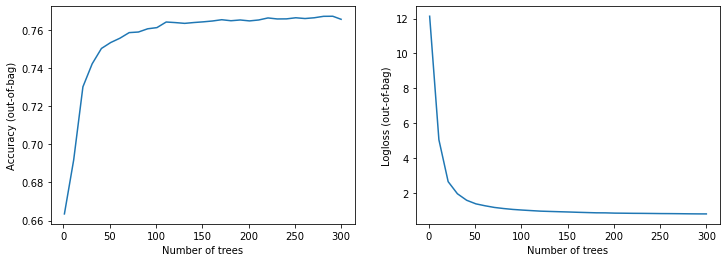

In [18]:
make_figure(model_rf)

## Random Forest con SMOTE

Repetimos el procedimiento con los datos SMOTE. Esperamos obtener un mal rendimiento, al igual que en redes neuronales.

In [19]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=2)

Convertimos los datos de las columnas categóricas a números para poder usar _SMOTE_

In [20]:
cat_columns = ['wkc', 'wrc', 'bkc']

data[cat_columns]=data[cat_columns].astype("category")
data[cat_columns]=data[cat_columns].apply(lambda x: x.cat.codes)
data.astype('int64')

,wkc,wkr,wrc,wrr,bkc,bkr,opt rank
0,0,1,1,3,2,2,0
1,0,1,2,1,2,2,0
2,0,1,2,1,3,1,0
3,0,1,2,1,3,2,0
4,0,1,2,2,2,1,0
...,...,...,...,...,...,...,...
28051,1,1,6,7,4,5,17
28052,1,1,6,7,4,6,17
28053,1,1,6,7,4,7,17
28054,1,1,6,7,5,5,17


Aplicamos _SMOTE_

In [21]:
xsmote, ysmote = sm.fit_resample(data.drop(label, axis=1), data[label])
data_smote = pd.concat([xsmote, ysmote], axis=1)
data_smote

,wkc,wkr,wrc,wrr,bkc,bkr,opt rank
0,0,1,1,3,2,2,0
1,0,1,2,1,2,2,0
2,0,1,2,1,3,1,0
3,0,1,2,1,3,2,0
4,0,1,2,2,2,1,0
...,...,...,...,...,...,...,...
81949,0,1,5,7,3,2,17
81950,0,1,1,2,4,3,17
81951,0,1,6,6,4,3,17
81952,0,1,7,6,5,3,17


In [22]:
train_smote, test_smote = split_dataset(data_smote)
print("{} examples in training, {} examples for testing.".format(
    len(train_smote), len(test_smote)))

65416 examples in training, 16538 examples for testing.


Creamos los datasets train y test para que pueda usarlos la librería. Notemos que los datos de las variables numéricas que hemos convertido se asignan a int8 automáticamente, a diferencia de las demás, que usan int64.

In [23]:
train_smote = tfdf.keras.pd_dataframe_to_tf_dataset(train_smote, label=label, )
test_smote = tfdf.keras.pd_dataframe_to_tf_dataset(test_smote, label=label)

In [24]:
train_smote

<BatchDataset shapes: ({wkc: (None,), wkr: (None,), wrc: (None,), wrr: (None,), bkc: (None,), bkr: (None,)}, (None,)), types: ({wkc: tf.int8, wkr: tf.int64, wrc: tf.int8, wrr: tf.int64, bkc: tf.int8, bkr: tf.int64}, tf.int64)>

In [25]:
model_1_smote = tfdf.keras.RandomForestModel()

model_1_smote.compile(
                metrics=["accuracy"])

model_1_smote.fit(x=train_smote)

ValueError: in user code:

    /home/antonio/anaconda3/envs/tf2.5/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:855 train_function  *
        return step_function(self, iterator)
    /home/antonio/anaconda3/envs/tf2.5/lib/python3.8/site-packages/tensorflow_decision_forests/keras/core.py:646 train_step  *
        normalized_semantic_inputs = tf_core.normalize_inputs(semantic_inputs)
    /home/antonio/anaconda3/envs/tf2.5/lib/python3.8/site-packages/tensorflow_decision_forests/tensorflow/core.py:255 normalize_inputs  *
        raise ValueError(

    ValueError: Non supported tensor dtype <dtype: 'int8'> for semantic Semantic.CATEGORICAL of feature wkc


Sorpresa. No somos capaces de crear el modelo ya que las variables deben estar codificadas en tf.int64. Pero al usar la función para crear el dataset, como hemos comentado antes, no es posible cambiar el tipo. Aunque definamos inicialmente todas las columnas como int64, la función las cambia a tf.int8.

Este bug nos impide comprobar el rendimiento de SMOTE. Suponemos que se solucionará en versiones siguientes. El método con _one-hot_ encoding tampoco funcionará ya que también es convertido a tf.int8.

## Datos raw con boosted trees

El siguiente algoritmo que vamos a probar es _Gradient Boosted Trees_. En estos modelos, se crean un conjunto de árboles los cuales son mejorados iterativamente mediante _boosting_. A diferencia de _AdaBoost_, se mejoran las predicciones reduciendo el error con una función de coste.

Este algoritmo permite modificar ciertos parámetros, por los que realizaremos distintas pruebas y ver su rendimiento.

In [26]:
model_bt_1 = tfdf.keras.GradientBoostedTreesModel(num_trees=500, 
                                                  growing_strategy="BEST_FIRST_GLOBAL",
                                                  max_depth=8)
model_bt_1.fit(x=train)
model_bt_1.summary()

351/351 [==============================] - 0s 1ms/step
Model: "gradient_boosted_trees_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "GRADIENT_BOOSTED_TREES"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (6):
	bkc
	bkr
	wkc
	wkr
	wrc
	wrr

No weights

Variable Importance: NUM_NODES:
    1. "wrr" 50164.000000 ################
    2. "wrc" 46244.000000 #############
    3. "bkc" 39981.000000 ##########
    4. "bkr" 37646.000000 #########
    5. "wkr" 27136.000000 ###
    6. "wkc" 21299.000000 

Variable Importance: NUM_AS_ROOT:
    1. "bkr" 2894.000000 ################
    2. "bkc" 1723.000000 ########
    3. "wkc" 980.000000 ###
    4. "wkr" 932.000000 ###
    5. "wrr" 499.000000 
    6. "wrc" 388.000000 

Variable Importance: SUM_SCORE:
    1. "bkr" 9447.080

Hemos creado y entrenado un modelo con 300 árboles y una profundidad máxima de 8. Veamos las métricas obtenidas:

In [28]:
preds = model_bt_1.predict(test)
preds = np.argmax(preds, axis=1)

metrics_bt_1= compute_metrics_multiclass(y_test_aux, preds)
metrics_bt_1

[0.8913663931501962,
 0.8913663931501962,
 0.8913663931501962,
 0.8785774841048029]

Los resultados son mucho mejores. Obtenemos un 89% en Precision, Recall y F1. Hemos alcanzado los mejores resultados de las redes neuronales en el caso de dropout y 6 capas internas de 250 neuronas con un modelo mucho más rápido y simple de construir. Recordemos que los resultados son deterministas y que sólo es necesario una "época" a diferencia de las redes neuronales.

Creamos otro modelo en el que aportamos más parámetros para el entrenamiento, los cuales se recomiendan en la documentación y tutoriales de la librería.

In [29]:
model_bt_2 = tfdf.keras.GradientBoostedTreesModel(
    num_trees=500,
    growing_strategy="BEST_FIRST_GLOBAL",
    max_depth=8,
    split_axis="SPARSE_OBLIQUE",
    categorical_algorithm="RANDOM",
    )
model_bt_2.fit(x=train)
model_bt_2.summary()


351/351 [==============================] - 0s 1ms/step
Model: "gradient_boosted_trees_model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "GRADIENT_BOOSTED_TREES"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (6):
	bkc
	bkr
	wkc
	wkr
	wrc
	wrr

No weights

Variable Importance: NUM_NODES:
    1. "bkr" 80207.000000 ################
    2. "wrc" 44066.000000 #######
    3. "bkc" 39708.000000 ######
    4. "wkr" 24787.000000 ###
    5. "wkc" 19797.000000 ##
    6. "wrr" 9051.000000 

Variable Importance: NUM_AS_ROOT:
    1. "bkr" 3933.000000 ################
    2. "bkc" 1479.000000 #####
    3. "wkc" 933.000000 ###
    4. "wkr" 606.000000 ##
    5. "wrc" 251.000000 
    6. "wrr" 52.000000 

Variable Importance: SUM_SCORE:
    1. "bkr" 16701.633258 ################

In [30]:
preds = model_bt_2.predict(test)
preds = np.argmax(preds, axis=1)

metrics_bt_2= compute_metrics_multiclass(y_test_aux, preds)
metrics_bt_2

[0.881198715661791, 0.881198715661791, 0.881198715661791, 0.8672254847683257]

Los resultados siguen siendo muy buenos pero empeoran levemente con respecto a los parámetros por defecto.

La librería implementa algunas plantillas de parámetros que, según la documentación, proveen mejores resultados que los parámetros por defecto.

Estos son:

In [31]:
print(tfdf.keras.GradientBoostedTreesModel.predefined_hyperparameters())

[HyperParameterTemplate(name='better_default', version=1, parameters={'growing_strategy': 'BEST_FIRST_GLOBAL'}, description='A configuration that is generally better than the default parameters without being more expensive.'), HyperParameterTemplate(name='benchmark_rank1', version=1, parameters={'growing_strategy': 'BEST_FIRST_GLOBAL', 'categorical_algorithm': 'RANDOM', 'split_axis': 'SPARSE_OBLIQUE', 'sparse_oblique_normalization': 'MIN_MAX', 'sparse_oblique_num_projections_exponent': 1.0}, description='Top ranking hyper-parameters on our benchmark slightly modified to run in reasonable time.')]


Podemos probar "benchmark_rank1", que ofreció los mejores resultados en sus benchmarks.

In [32]:
model_bt_3 = tfdf.keras.GradientBoostedTreesModel(
    hyperparameter_template="benchmark_rank1")

model_bt_3.fit(x=train)
model_bt_3.summary()


351/351 [==============================] - 0s 1ms/step
Model: "gradient_boosted_trees_model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "GRADIENT_BOOSTED_TREES"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (6):
	bkc
	bkr
	wkc
	wkr
	wrc
	wrr

No weights

Variable Importance: NUM_NODES:
    1. "bkr" 59503.000000 ################
    2. "wrc" 34820.000000 ########
    3. "bkc" 33116.000000 ########
    4. "wkc" 14859.000000 ##
    5. "wkr" 14090.000000 ##
    6. "wrr" 5583.000000 

Variable Importance: NUM_AS_ROOT:
    1. "bkr" 3037.000000 ################
    2. "bkc" 958.000000 ####
    3. "wkc" 830.000000 ####
    4. "wkr" 418.000000 #
    5. "wrc" 90.000000 
    6. "wrr" 67.000000 

Variable Importance: SUM_SCORE:
    1. "bkr" 16677.602664 ################


In [33]:
preds = model_bt_3.predict(test)
preds = np.argmax(preds, axis=1)

metrics_bt_3= compute_metrics_multiclass(y_test_aux, preds)
metrics_bt_3

[0.8555119514805566,
 0.8555119514805566,
 0.8555119514805566,
 0.8384821966216377]

Obtenemos los peores resultados. Es curioso que la mejor configuración de parámetros en las pruebas de Google haya producido estas métricas.

## Creación de árboles con modelos CART con datos _raw_

Probamos ahora la función _CartModel_, variación del famoso C4.5. Este tipo de clasificadores han aparecido en otras asignaturas del máster y provee muy buenos resultados.

In [35]:
model_CART_1 = tfdf.keras.CartModel()

model_CART_1.fit(x=train)
model_CART_1.summary()


351/351 [==============================] - 0s 1ms/step
Model: "cart_model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (6):
	bkc
	bkr
	wkc
	wkr
	wrc
	wrr

No weights

Variable Importance: NUM_NODES:
    1. "wrr" 267.000000 ################
    2. "wrc" 202.000000 ###########
    3. "bkr" 128.000000 #####
    4. "bkc" 113.000000 ####
    5. "wkc" 79.000000 ##
    6. "wkr" 45.000000 

Variable Importance: NUM_AS_ROOT:
    1. "bkr"  1.000000 

Variable Importance: SUM_SCORE:
    1. "bkr" 6537.829253 ################
    2. "wrc" 6219.915177 ##############
    3. "wrr" 6025.801832 #############
    4. "bkc" 5914.132091 ############
    5. "wkr" 4833.035964 ######
    6. "wkc" 3554.173828 

Variable Impo

In [36]:
preds = model_CART_1.predict(test)
preds = np.argmax(preds, axis=1)

metrics_CART_1= compute_metrics_multiclass(y_test_aux, preds)
metrics_CART_1

[0.6307527648947556,
 0.6307527648947556,
 0.6307527648947556,
 0.5866906674682764]

Obtenemos unos malos resultados con un 63% de Precision, F1 y Recall. Es lógico, ya que tanto RandomForest como BoostedTrees ofrecen mejores resultados que CART al usar éste último un único árbol.

## Comparación eficiencia RandomForest de Tensorflow vs Scikit-Learn

En el apartado de análisis exploratorio de datos usamos RandomForest con la librería Scikit-Learn para estudiar las variables predictoras con más importancia. Podemos pensar qué ventajas aporta esta nueva librería de TensorFlow frente a la ya mencionada anterioremente.

Hay aspectos claros, la librería de TensorFlow ofrece una mayor integración en el ecosistema y permite crear modelos de árboles que interactúen con redes neuronales de Keras. Además, el número de métodos de las clases así como los parámetros de customización son mayores (recomendamos ver la documentación de la API).

Nos preguntamos si, al usar la librería Yggdrasil _under the hood_, obtenemos una mayor rápidez.

Para ello creamos dos modelos de RandomForest con ambas librerías. Los dos tienen la misma configuración: 300 árboles y una profundidad máxima de 8 nodos.

In [45]:
from sklearn.ensemble import RandomForestClassifier

train_sk, test_sk = split_dataset(data)

clf = RandomForestClassifier(max_depth=8,
                             random_state=0,
                             n_estimators=300)

%timeit clf.fit(train_sk.drop('opt rank', axis=1), train_sk['opt rank'])

2.21 s ± 541 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [46]:
model = tfdf.keras.RandomForestModel(max_depth=8,
                                     num_trees=300)

%timeit model.fit(train)

351/351 [==============================] - 0s 1ms/step


351/351 [==============================] - 0s 1ms/step


351/351 [==============================] - 0s 1ms/step
449 ms ± 4.69 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Mientras que la función de la librería Scikit-learn ha necesitado 2.21 s (de media) para realizar el entrenamiento, la función de TensorFlow lo ha hecho en 449 ms, unas cinco veces más rápido.

Vemos que la nueva librería ofrece resultados más rápidos. Intuimos que la diferencia en tiempos aumentará de forma notable al usar dataset más grandes y con configuraciones de árboles más complejas.


## Conclusiones

Mostramos los resultados de las métricas obtenidas por los algoritmos usados en este apartado:

In [60]:
metricas = [metrics_rf, metrics_bt_1, metrics_bt_2, metrics_bt_3, metrics_CART_1]
precision = []
recall = []
f1 = []
cohen_kappa = []

for metrica in metricas:
    precision.append(metrica[0])
    recall.append(metrica[1])
    f1.append(metrica[2])
    cohen_kappa.append(metrica[3])
    
data = {"Modelo" : ["Random Forest", "BT por defecto", "BT más complejo", "BT mejor benchmark","CART"],
        "Precision" : precision,
       "Recall": recall,
       "F1" : f1,
       "Cohen kappa" : cohen_kappa}
pd.DataFrame(data)

,Modelo,Precision,Recall,F1,Cohen kappa
0,Random Forest,0.768284,0.768284,0.768284,0.740887
1,BT por defecto,0.891366,0.891366,0.891366,0.878577
2,BT más complejo,0.881199,0.881199,0.881199,0.867225
3,BT mejor benchmark,0.855512,0.855512,0.855512,0.838482
4,CART,0.630753,0.630753,0.630753,0.586691


En la peor posición encontramos el algoritmo de tipo CART. Lógico, ya que solo crea un árbol mientras que los demás usan ensembles.
Random Forest obtiene aproximadamente un 76% en las métricas, pero es superado por rendimiento por todas las pruebas de Boosted Trees.

En las configuraciones utilizadas, los parámetros por defecto obtienen mejores resultados (89% en Precision, Recall y F1) que el modelo más complejo y usando la plantilla recomendada por la librería que ofrecía mejores resultados.

Además hemos comprobado que esta librería es más eficiente en tiempo computacional que los algoritmos incluidos en la librería Scikit-Learn

En conclusión, hemos obtenido unos resultados que igualan a los mejores conseguidos con redes neuronales con unos modelos mucho más fáciles de configurar y más rápidos de entrenar.